In [11]:
import paddle
import interpretdl as it
from interpretdl.data_processor.visualizer import _grayscale

#### Custom trained ResNet50 for SmoothGrad

In [51]:
ResNet50 = paddle.vision.models.resnet50(pretrained=False, num_classes=5)
ResNet50_param_path = r"/Users/jack/Desktop/jack_code/InterpretDL/infer/model_params/latest.pdparams"
ResNet50_state_dict = paddle.load(ResNet50_param_path)
ResNet50.set_dict(ResNet50_state_dict)

/opt/anaconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1483: UserWarning: Skip loading for conv1.weight. conv1.weight is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/anaconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1483: UserWarning: Skip loading for bn1.weight. bn1.weight is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/anaconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1483: UserWarning: Skip loading for bn1.bias. bn1.bias is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/anaconda3/envs/paddle/lib/python3.8/site-packages/paddle/fluid/dygraph/layers.py:1483: UserWarning: Skip loading for bn1._mean. bn1._mean is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/anaconda3/env

In [52]:
# 查看resent50的结构
resnet50_result = [n for n, v in ResNet50.named_sublayers()]
print(resnet50_result)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.relu', 'layer1.0.downsample', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.relu', 'layer1.2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.relu', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.relu', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.conv3', 'layer2.1.bn3', 'layer2.1.relu', 'layer2.2', 'layer2.2.conv1', 'layer2.2.bn1', 'layer2.2.conv2', 'layer2.2.bn2', 'layer2.2.conv3', 'layer2.2.bn3', 'layer2.2.relu', 'layer2.3', 

100%|███████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


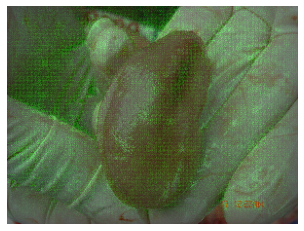

In [55]:
resnet50_sg = it.SmoothGradInterpreter(ResNet50, use_cuda=False) # 将mobilenetv1加到SmoothGrad可解释性算法中
resnet50sg_gradients = resnet50_sg.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg",visual=True, save_path=None)

#### Custom trained ResNet50 for GradCAM

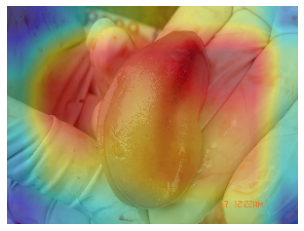

In [57]:
resnet50_gc = it.GradCAMInterpreter(ResNet50, use_cuda=False)
resnet50_gc_gradients = resnet50_gc.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg","layer4.2.conv1",visual=True, save_path=None)

#### Pretrained ResNet50 for SmoothGrad

Paddle is not installed with GPU support. Change to CPU version now.


100%|███████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


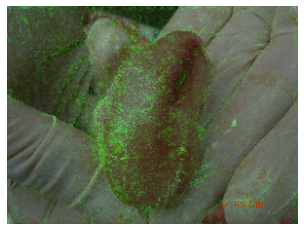

In [58]:
ResNet50 = paddle.vision.models.resnet50(pretrained=True, num_classes=5)
resnet50_sg = it.SmoothGradInterpreter(ResNet50,use_cuda=False) # 将resnet50加到SmoothGrad可解释性算法中
resnet50_sg_gradients = resnet50_sg.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg",visual=True, save_path=None)

#### Pretrained ResNet50 for GradCAM

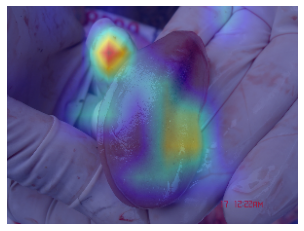

In [59]:
ResNet50 = paddle.vision.models.resnet50(pretrained=True, num_classes=5)
resnet50_sg = it.GradCAMInterpreter(ResNet50,use_cuda=False) # 将resnet50加到SmoothGrad可解释性算法中
resnet50_sg_gradients = resnet50_sg.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg","layer4.2.conv1",visual=True, save_path=None)

### 从paddleclas源码中构造Resnet50_vd

In [141]:
# copyright (c) 2021 PaddlePaddle Authors. All Rights Reserve.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import absolute_import, division, print_function

import numpy as np
import paddle
from paddle import ParamAttr
import paddle.nn as nn
from paddle.nn import Conv2D, BatchNorm, Linear
from paddle.nn import AdaptiveAvgPool2D, MaxPool2D, AvgPool2D
from paddle.nn.initializer import Uniform
import math

from ppcls.arch.backbone.base.theseus_layer import TheseusLayer
from ppcls.utils.save_load import load_dygraph_pretrain, load_dygraph_pretrain_from_url

MODEL_URLS = {
    "ResNet18":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet18_pretrained.pdparams",
    "ResNet18_vd":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet18_vd_pretrained.pdparams",
    "ResNet34":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet34_pretrained.pdparams",
    "ResNet34_vd":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet34_vd_pretrained.pdparams",
    "ResNet50":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet50_pretrained.pdparams",
    "ResNet50_vd":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet50_vd_pretrained.pdparams",
    "ResNet101":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet101_pretrained.pdparams",
    "ResNet101_vd":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet101_vd_pretrained.pdparams",
    "ResNet152":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet152_pretrained.pdparams",
    "ResNet152_vd":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet152_vd_pretrained.pdparams",
    "ResNet200_vd":
    "https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet200_vd_pretrained.pdparams",
}

MODEL_STAGES_PATTERN = {
    "ResNet18": ["blocks[1]", "blocks[3]", "blocks[5]", "blocks[7]"],
    "ResNet34": ["blocks[2]", "blocks[6]", "blocks[12]", "blocks[15]"],
    "ResNet50": ["blocks[2]", "blocks[6]", "blocks[12]", "blocks[15]"],
    "ResNet101": ["blocks[2]", "blocks[6]", "blocks[29]", "blocks[32]"],
    "ResNet152": ["blocks[2]", "blocks[10]", "blocks[46]", "blocks[49]"],
    "ResNet200": ["blocks[2]", "blocks[14]", "blocks[62]", "blocks[65]"]
}

__all__ = MODEL_URLS.keys()
'''
ResNet config: dict.
    key: depth of ResNet.
    values: config's dict of specific model.
        keys:
            block_type: Two different blocks in ResNet, BasicBlock and BottleneckBlock are optional.
            block_depth: The number of blocks in different stages in ResNet.
            num_channels: The number of channels to enter the next stage.
'''
NET_CONFIG = {
    "18": {
        "block_type": "BasicBlock",
        "block_depth": [2, 2, 2, 2],
        "num_channels": [64, 64, 128, 256]
    },
    "34": {
        "block_type": "BasicBlock",
        "block_depth": [3, 4, 6, 3],
        "num_channels": [64, 64, 128, 256]
    },
    "50": {
        "block_type": "BottleneckBlock",
        "block_depth": [3, 4, 6, 3],
        "num_channels": [64, 256, 512, 1024]
    },
    "101": {
        "block_type": "BottleneckBlock",
        "block_depth": [3, 4, 23, 3],
        "num_channels": [64, 256, 512, 1024]
    },
    "152": {
        "block_type": "BottleneckBlock",
        "block_depth": [3, 8, 36, 3],
        "num_channels": [64, 256, 512, 1024]
    },
    "200": {
        "block_type": "BottleneckBlock",
        "block_depth": [3, 12, 48, 3],
        "num_channels": [64, 256, 512, 1024]
    },
}


class ConvBNLayer(TheseusLayer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 is_vd_mode=False,
                 act=None,
                 lr_mult=1.0,
                 data_format="NCHW"):
        super().__init__()
        self.is_vd_mode = is_vd_mode
        self.act = act
        self.avg_pool = AvgPool2D(
            kernel_size=2, stride=2, padding=0, ceil_mode=True)
        self.conv = Conv2D(
            in_channels=num_channels,
            out_channels=num_filters,
            kernel_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            weight_attr=ParamAttr(learning_rate=lr_mult),
            bias_attr=False,
            data_format=data_format)
        self.bn = BatchNorm(
            num_filters,
            param_attr=ParamAttr(learning_rate=lr_mult),
            bias_attr=ParamAttr(learning_rate=lr_mult),
            data_layout=data_format)
        self.relu = nn.ReLU()

    def forward(self, x):
        if self.is_vd_mode:
            x = self.avg_pool(x)
        x = self.conv(x)
        x = self.bn(x)
        if self.act:
            x = self.relu(x)
        return x


class BottleneckBlock(TheseusLayer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True,
                 if_first=False,
                 lr_mult=1.0,
                 data_format="NCHW"):
        super().__init__()

        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act="relu",
            lr_mult=lr_mult,
            data_format=data_format)
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act="relu",
            lr_mult=lr_mult,
            data_format=data_format)
        self.conv2 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None,
            lr_mult=lr_mult,
            data_format=data_format)

        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride if if_first else 1,
                is_vd_mode=False if if_first else True,
                lr_mult=lr_mult,
                data_format=data_format)
        self.relu = nn.ReLU()
        self.shortcut = shortcut

    def forward(self, x):
        identity = x
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)

        if self.shortcut:
            short = identity
        else:
            short = self.short(identity)
        x = paddle.add(x=x, y=short)
        x = self.relu(x)
        return x


class BasicBlock(TheseusLayer):
    def __init__(self,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True,
                 if_first=False,
                 lr_mult=1.0,
                 data_format="NCHW"):
        super().__init__()

        self.stride = stride
        self.conv0 = ConvBNLayer(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act="relu",
            lr_mult=lr_mult,
            data_format=data_format)
        self.conv1 = ConvBNLayer(
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            act=None,
            lr_mult=lr_mult,
            data_format=data_format)
        if not shortcut:
            self.short = ConvBNLayer(
                num_channels=num_channels,
                num_filters=num_filters,
                filter_size=1,
                stride=stride if if_first else 1,
                is_vd_mode=False if if_first else True,
                lr_mult=lr_mult,
                data_format=data_format)
        self.shortcut = shortcut
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv0(x)
        x = self.conv1(x)
        if self.shortcut:
            short = identity
        else:
            short = self.short(identity)
        x = paddle.add(x=x, y=short)
        x = self.relu(x)
        return x


class ResNet(TheseusLayer):
    """
    ResNet
    Args:
        config: dict. config of ResNet.
        version: str="vb". Different version of ResNet, version vd can perform better. 
        class_num: int=1000. The number of classes.
        lr_mult_list: list. Control the learning rate of different stages.
    Returns:
        model: nn.Layer. Specific ResNet model depends on args.
    """

    def __init__(self,
                 config,
                 stages_pattern,
                 version="vb",
                 class_num=1000,
                 lr_mult_list=[1.0, 1.0, 1.0, 1.0, 1.0],
                 data_format="NCHW",
                 input_image_channel=3,
                 return_patterns=None,
                 return_stages=None):
        super().__init__()

        self.cfg = config
        self.lr_mult_list = lr_mult_list
        self.is_vd_mode = version == "vd"
        self.class_num = class_num
        self.num_filters = [64, 128, 256, 512]
        self.block_depth = self.cfg["block_depth"]
        self.block_type = self.cfg["block_type"]
        self.num_channels = self.cfg["num_channels"]
        self.channels_mult = 1 if self.num_channels[-1] == 256 else 4

        assert isinstance(self.lr_mult_list, (
            list, tuple
        )), "lr_mult_list should be in (list, tuple) but got {}".format(
            type(self.lr_mult_list))
        assert len(self.lr_mult_list
                   ) == 5, "lr_mult_list length should be 5 but got {}".format(
                       len(self.lr_mult_list))

        self.stem_cfg = {
            #num_channels, num_filters, filter_size, stride
            "vb": [[input_image_channel, 64, 7, 2]],
            "vd":
            [[input_image_channel, 32, 3, 2], [32, 32, 3, 1], [32, 64, 3, 1]]
        }

        self.stem = nn.Sequential(* [
            ConvBNLayer(
                num_channels=in_c,
                num_filters=out_c,
                filter_size=k,
                stride=s,
                act="relu",
                lr_mult=self.lr_mult_list[0],
                data_format=data_format)
            for in_c, out_c, k, s in self.stem_cfg[version]
        ])

        self.max_pool = MaxPool2D(
            kernel_size=3, stride=2, padding=1, data_format=data_format)
        block_list = []
        for block_idx in range(len(self.block_depth)):
            shortcut = False
            for i in range(self.block_depth[block_idx]):
                block_list.append(globals()[self.block_type](
                    num_channels=self.num_channels[block_idx] if i == 0 else
                    self.num_filters[block_idx] * self.channels_mult,
                    num_filters=self.num_filters[block_idx],
                    stride=2 if i == 0 and block_idx != 0 else 1,
                    shortcut=shortcut,
                    if_first=block_idx == i == 0 if version == "vd" else True,
                    lr_mult=self.lr_mult_list[block_idx + 1],
                    data_format=data_format))
                shortcut = True
        self.blocks = nn.Sequential(*block_list)

        self.avg_pool = AdaptiveAvgPool2D(1, data_format=data_format)
        self.flatten = nn.Flatten()
        self.avg_pool_channels = self.num_channels[-1] * 2
        stdv = 1.0 / math.sqrt(self.avg_pool_channels * 1.0)
        self.fc = Linear(
            self.avg_pool_channels,
            self.class_num,
            weight_attr=ParamAttr(initializer=Uniform(-stdv, stdv)))

        self.data_format = data_format

        super().init_res(
            stages_pattern,
            return_patterns=return_patterns,
            return_stages=return_stages)

    def forward(self, x):
        with paddle.static.amp.fp16_guard():
            if self.data_format == "NHWC":
                x = paddle.transpose(x, [0, 2, 3, 1])
                x.stop_gradient = True
            x = self.stem(x)
            x = self.max_pool(x)
            x = self.blocks(x)
            x = self.avg_pool(x)
            x = self.flatten(x)
            x = self.fc(x)
        return x


def _load_pretrained(pretrained, model, model_url, use_ssld):
    if pretrained is False:
        pass
    elif pretrained is True:
        load_dygraph_pretrain_from_url(model, model_url, use_ssld=use_ssld)
    elif isinstance(pretrained, str):
        load_dygraph_pretrain(model, pretrained)
    else:
        raise RuntimeError(
            "pretrained type is not available. Please use `string` or `boolean` type."
        )


def ResNet18(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet18
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet18` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["18"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet18"],
        version="vb",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet18"], use_ssld)
    return model


def ResNet18_vd(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet18_vd
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet18_vd` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["18"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet18"],
        version="vd",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet18_vd"], use_ssld)
    return model


def ResNet34(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet34
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet34` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["34"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet34"],
        version="vb",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet34"], use_ssld)
    return model


def ResNet34_vd(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet34_vd
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet34_vd` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["34"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet34"],
        version="vd",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet34_vd"], use_ssld)
    return model


def ResNet50(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet50
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet50` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["50"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet50"],
        version="vb",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet50"], use_ssld)
    return model


def ResNet50_vd(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet50_vd
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet50_vd` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["50"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet50"],
        version="vd",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet50_vd"], use_ssld)
    return model


def ResNet101(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet101
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet101` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["101"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet101"],
        version="vb",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet101"], use_ssld)
    return model


def ResNet101_vd(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet101_vd
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet101_vd` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["101"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet101"],
        version="vd",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet101_vd"], use_ssld)
    return model


def ResNet152(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet152
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet152` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["152"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet152"],
        version="vb",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet152"], use_ssld)
    return model


def ResNet152_vd(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet152_vd
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet152_vd` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["152"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet152"],
        version="vd",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet152_vd"], use_ssld)
    return model


def ResNet200_vd(pretrained=False, use_ssld=False, **kwargs):
    """
    ResNet200_vd
    Args:
        pretrained: bool=False or str. If `True` load pretrained parameters, `False` otherwise.
                    If str, means the path of the pretrained model.
        use_ssld: bool=False. Whether using distillation pretrained model when pretrained=True.
    Returns:
        model: nn.Layer. Specific `ResNet200_vd` model depends on args.
    """
    model = ResNet(
        config=NET_CONFIG["200"],
        stages_pattern=MODEL_STAGES_PATTERN["ResNet200"],
        version="vd",
        **kwargs)
    _load_pretrained(pretrained, model, MODEL_URLS["ResNet200_vd"], use_ssld)
    return model


In [142]:
ResNet50_vd_custom_trained = ResNet50_vd(pretrained=False, class_num=5)
# print(resnet50_vd)
ResNet50_vd_result = [n for n, v in ResNet50_vd_custom_trained.named_sublayers()]
print(ResNet50_vd_result)

['stem', 'stem.0', 'stem.0.avg_pool', 'stem.0.conv', 'stem.0.bn', 'stem.0.relu', 'stem.1', 'stem.1.avg_pool', 'stem.1.conv', 'stem.1.bn', 'stem.1.relu', 'stem.2', 'stem.2.avg_pool', 'stem.2.conv', 'stem.2.bn', 'stem.2.relu', 'max_pool', 'blocks', 'blocks.0', 'blocks.0.conv0', 'blocks.0.conv0.avg_pool', 'blocks.0.conv0.conv', 'blocks.0.conv0.bn', 'blocks.0.conv0.relu', 'blocks.0.conv1', 'blocks.0.conv1.avg_pool', 'blocks.0.conv1.conv', 'blocks.0.conv1.bn', 'blocks.0.conv1.relu', 'blocks.0.conv2', 'blocks.0.conv2.avg_pool', 'blocks.0.conv2.conv', 'blocks.0.conv2.bn', 'blocks.0.conv2.relu', 'blocks.0.short', 'blocks.0.short.avg_pool', 'blocks.0.short.conv', 'blocks.0.short.bn', 'blocks.0.short.relu', 'blocks.0.relu', 'blocks.1', 'blocks.1.conv0', 'blocks.1.conv0.avg_pool', 'blocks.1.conv0.conv', 'blocks.1.conv0.bn', 'blocks.1.conv0.relu', 'blocks.1.conv1', 'blocks.1.conv1.avg_pool', 'blocks.1.conv1.conv', 'blocks.1.conv1.bn', 'blocks.1.conv1.relu', 'blocks.1.conv2', 'blocks.1.conv2.avg_po

In [144]:
# 加载模型参数
ResNet50_vd_param_path = r"/Users/jack/Desktop/jack_code/InterpretDL/infer/model_params/latest.pdparams"
ResNet50_vd_state_dict = paddle.load(ResNet50_vd_param_path)
ResNet50_vd_custom_trained.set_dict(ResNet50_vd_state_dict)

#### Custom trained ResNet50_vd for SmoothGrad

100%|███████████████████████████████████████████| 50/50 [01:06<00:00,  1.33s/it]


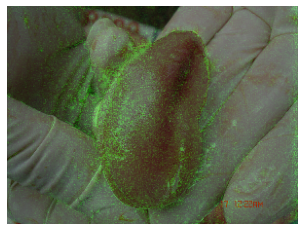

In [145]:
resnet50_vd_custom_trained_sg = it.SmoothGradInterpreter(ResNet50_vd_custom_trained,use_cuda=False) # 将resnet50_vd加到SmoothGrad可解释性算法中
resnet50_sg_gradients = resnet50_vd_custom_trained_sg.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg",visual=True, save_path=None)

#### Custom trained ResNet50_vd for GradCAM

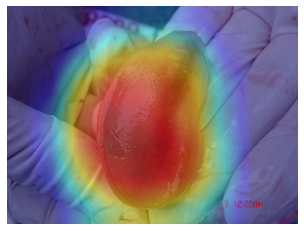

In [146]:
resnet50_vd_custom_trained_gc = it.GradCAMInterpreter(ResNet50_vd_custom_trained,use_cuda=False) # 将resnet50_vd加到GradCAM可解释性算法中
resnet50_vd_sg_gradients = resnet50_vd_custom_trained_gc.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg","blocks.15.conv2.conv",visual=True, save_path=None)

#### Pretrained ResNet50_vd for SmoothGrad

In [160]:
# 生成Resnet50_vd
ResNet50_vd_pretrained= ResNet50_vd(pretrained=False, class_num=5)
# 加载源码提供的预训练模型参数
ResNet50_vd_pretrained_param_path = r"/Users/jack/Desktop/jack_code/InterpretDL/infer/model_params/ResNet50_vd_pretrained.pdparams"
ResNet50_vd_pretrained_state_dict = paddle.load(ResNet50_vd_pretrained_param_path)
ResNet50_vd_pretrained.set_dict(ResNet50_vd_pretrained_state_dict)

/Users/jack/Desktop/jack_code/InterpretDL/interpretdl/interpreter/abc_interpreter.py:110: UserWarning: ``use_cuda`` would be deprecated soon. Use ``device`` directly.
  Interpreter.__init__(self, paddle_model, device, use_cuda, **kwargs)
100%|███████████████████████████████████████████| 50/50 [01:11<00:00,  1.43s/it]


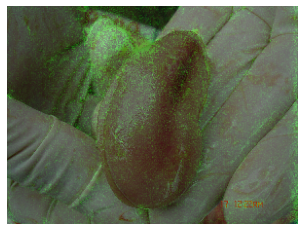

In [156]:
resnet50_vd_pretrained_sg = it.SmoothGradInterpreter(ResNet50_vd_pretrained,use_cuda=False) # 将resnet50_vd加到SmoothGrad可解释性算法中
resnet50_vd_pretrained_sg_gradients = resnet50_vd_pretrained_sg.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg",visual=True, save_path=None)

#### Pretrained ResNet50_vd for GradCAM

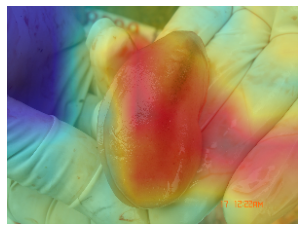

In [161]:
resnet50_vd_pretrained_gc = it.GradCAMInterpreter(ResNet50_vd_pretrained,use_cuda=False) # 将resnet50_vd加到GradCAM可解释性算法中
resnet50_vd_pretrained_gc_gradients = resnet50_vd_pretrained_gc.interpret("/Users/jack/Desktop/jack_code/InterpretDL/imgs/shenzang.jpg","blocks.15.conv2.conv",visual=True, save_path=None)